In [1]:
# --- SETUP ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')


# Cargar archivo .env
# Ruta relativa desde el notebook hasta el .env
dotenv_path = '../generadores/.env'  #

# Cargar el archivo .env desde la ruta especificada
load_dotenv(dotenv_path=dotenv_path)

# Leer variables de entorno
username = os.getenv("USUARIO_DB")
password = os.getenv("CLAVE_BD")

# Validar que se cargaron bien
print("Usuario:", username)
print("Contraseña cargada:", bool(password))  # No imprime la clave, pero verifica si existe

if not username or not password:
    raise ValueError("Las variables de entorno USUARIO_DB o CLAVE_BD no están definidas")

# Cadena de conexión
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=upgradeserver-vf.database.windows.net;'
    'DATABASE=Banco;'
    f'UID={username};'
    f'PWD={password};'
    'Connection Timeout=30;'
)

# Conexión
conn = pyodbc.connect(conn_str)



Usuario: vanesa
Contraseña cargada: True


In [2]:
usuarios = pd.read_sql_query("SELECT * FROM usuarios", conn)
empleo = pd.read_sql_query("SELECT usuario_id, salario, cargo FROM empleos", conn)
creditos = pd.read_sql_query("SELECT * FROM creditos", conn)
activos_financieros = pd.read_sql_query("SELECT usuario_id, tipo_activo, monto FROM activos_financieros", conn)



In [3]:
print(usuarios.columns)
print(empleo.columns)
print(creditos.columns)
print(activos_financieros.columns)


Index(['id', 'nombre', 'apellido', 'estado_civil', 'dni', 'nacionalidad',
       'fecha_nacimiento', 'direccion', 'codigo_postal', 'provincia',
       'telefono', 'email', 'es_moroso'],
      dtype='object')
Index(['usuario_id', 'salario', 'cargo'], dtype='object')
Index(['id', 'usuario_id', 'monto', 'fecha_inicio', 'fecha_fin', 'estado',
       'tipo'],
      dtype='object')
Index(['usuario_id', 'tipo_activo', 'monto'], dtype='object')


In [4]:
#union de tablas
usuarios = usuarios.rename(columns={'id': 'usuario_id'})

usuarios_empleo = usuarios.merge(
    empleo[['usuario_id', 'salario', 'cargo']], 
    on='usuario_id', 
    how='left'
)

usuarios_creditos = creditos.groupby('usuario_id').size().reset_index(name='cantidad_creditos')

usuarios_df = usuarios_empleo.merge(
    usuarios_creditos, 
    on='usuario_id', 
    how='left'
)

activos_totales = activos_financieros.groupby('usuario_id')['monto'].sum().reset_index(name='valor_activos')

usuarios_df = usuarios_df.merge(
    activos_totales, 
    on='usuario_id', 
    how='left'
)


In [5]:
# Limpieza
usuarios_df['cantidad_creditos'] = usuarios_df['cantidad_creditos'].fillna(0)
usuarios_df['valor_activos'] = usuarios_df['valor_activos'].fillna(0)
usuarios_df[['provincia', 'estado_civil', 'cargo', 'nacionalidad']] = usuarios_df[
    ['provincia', 'estado_civil', 'cargo', 'nacionalidad']].fillna("Desconocido")


In [6]:
# --- ENCODING & SCALING ---
from datetime import datetime

# Convertir a datetime si no lo está
usuarios_df['fecha_nacimiento'] = pd.to_datetime(usuarios_df['fecha_nacimiento'], errors='coerce')

# Calcular edad en años
hoy = pd.Timestamp('today')
usuarios_df['edad'] = (hoy - usuarios_df['fecha_nacimiento']).dt.days // 365

from sklearn.preprocessing import LabelEncoder, StandardScaler

cat_vars = ['provincia', 'estado_civil', 'cargo', 'nacionalidad']
for col in cat_vars:
    le = LabelEncoder()
    usuarios_df[col] = le.fit_transform(usuarios_df[col].astype(str))  # por si hay NaNs

features = ['edad', 'salario', 'provincia', 'estado_civil', 'cargo', 'cantidad_creditos', 'valor_activos']

X_scaled = StandardScaler().fit_transform(usuarios_df[features])


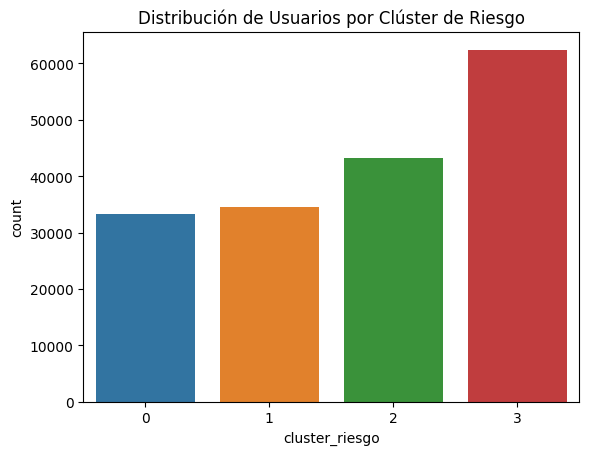

In [7]:
# --- CLUSTERING DE RIESGO ---
kmeans = KMeans(n_clusters=4, random_state=42)
usuarios_df['cluster_riesgo'] = kmeans.fit_predict(X_scaled)

sns.countplot(x='cluster_riesgo', data=usuarios_df, palette='tab10')
plt.title("Distribución de Usuarios por Clúster de Riesgo")
plt.show()

              precision    recall  f1-score   support

       False       1.00      0.98      0.99     21279
        True       0.99      1.00      0.99     30744

    accuracy                           0.99     52023
   macro avg       0.99      0.99      0.99     52023
weighted avg       0.99      0.99      0.99     52023



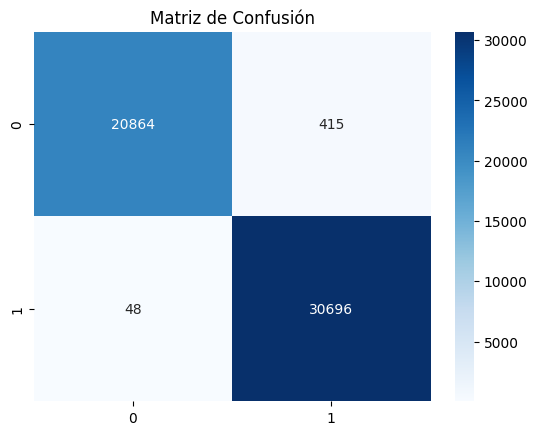

In [8]:
# --- PREDICCION DE MOROSIDAD ---
X = pd.DataFrame(X_scaled, columns=features)
y = usuarios_df['es_moroso']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

In [9]:
# --- VALIDACION CRUZADA ---
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Accuracy promedio (CV): {scores.mean():.4f}")

Accuracy promedio (CV): 0.6884


In [10]:
# --- GRIDSEARCHCV ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [11]:
print(type(y))
print(len(y))
print(y.head())
print(y.value_counts())


<class 'pandas.core.series.Series'>
173410
0    True
1    True
2    True
3    True
4    True
Name: es_moroso, dtype: bool
es_moroso
True     102850
False     70560
Name: count, dtype: int64


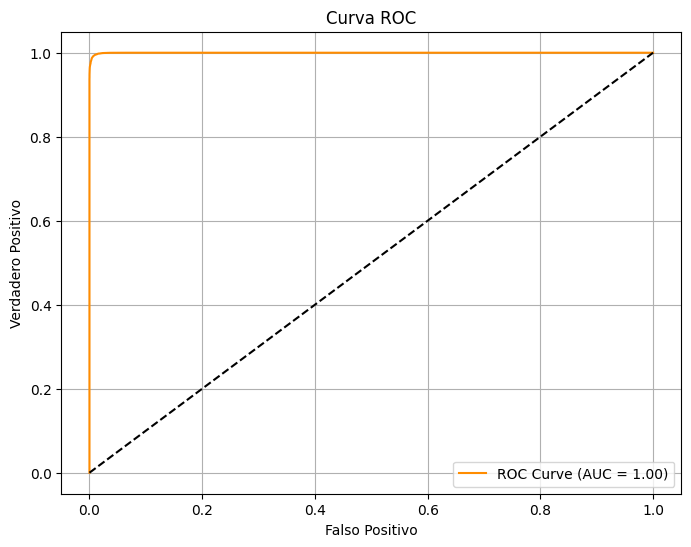

In [12]:
# --- CURVA ROC ---
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_scores = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print(np.unique(y_train))

[False  True]


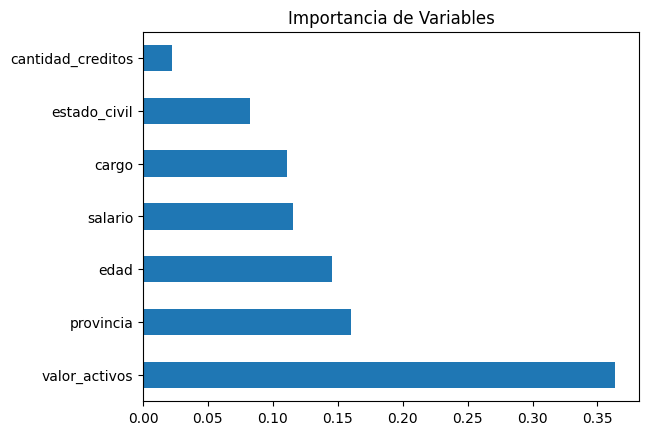

In [14]:
# --- IMPORTANCIA DE VARIABLES ---
importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind='barh', title='Importancia de Variables')
plt.show()